In [ ]:
!pip install "gdown"
!pip install "unsloth"
!pip install "seaborn"

import subprocess
import sys
import os
import warnings
import gdown
from datetime import datetime
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

warnings.filterwarnings('ignore')

In [ ]:
# CUDA check
try:
    import torch
    print(f"✅ PyTorch: {torch.__version__}")
    
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        vram_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✅ GPU: {gpu_name}")
        print(f"✅ VRAM: {vram_gb:.1f} GB")
        
        if vram_gb < 8:
            print("⚠️ Warning: > 8GB VRAM causes fragmentation issues at current.")
    else:
        print("❌ No CUDA GPU detected!")
        
except ImportError:
    print("❌ PyTorch not found")

try:
    from unsloth import FastLanguageModel
    from peft import PeftModel
    print("✅ Unsloth and PEFT available")
except ImportError as e:
    print(f"❌ Missing dependencies: {e}")
    print("Installing required packages...")

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        except:
            print(f"⚠️ Failed to install {package}")

✅ PyTorch: 2.7.0+cu128
✅ GPU: NVIDIA H200 NVL
✅ VRAM: 150.1 GB
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Unsloth and PEFT available


## Inference config

In [ ]:
CONFIG = {
    #defaults
    "base_model_name": "unsloth/llama-3-8b-Instruct",
    "finetuned_model_path": "llm",
    "max_seq_length": 2048,
    "max_new_tokens": 300,
    "temperature": 0.7,
    "top_p": 0.9,
    "repetition_penalty": 1.1,
    "load_in_4bit": False, 
}

# Auto-adjusts based on GPU
if torch.cuda.is_available():
    vram_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    if vram_gb >= 20:  
        CONFIG.update({
            "max_seq_length": 4096,
            "max_new_tokens": 500,
            "load_in_4bit": False,
        })
    elif vram_gb < 10: 
        CONFIG.update({
            "max_seq_length": 512,
            "max_new_tokens": 200,
        })

In [ ]:
# Helpers
def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def create_hansard_prompt(question):
    return f"""<|start_header_id|>system<|end_header_id|>
You are a helpful assistant specializing in parliamentary procedures and government documentation.<|eot_id|><|start_header_id|>user<|end_header_id|>
{question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

def score_response(response, question):
    """Score response quality (0-15 scale)"""
    score = 0
    
    # Length check
    if 50 <= len(response) <= 1000:
        score += 2
    elif 20 <= len(response) < 50:
        score += 1
    
    # Parliamentary terminology
    parliamentary_terms = [
        "parliament", "hansard", "parliamentary", "debate", "mps", "members",
        "house of commons", "house of lords", "legislation", "accountability",
        "transparency", "democratic", "proceedings", "committee", "motion",
        "amendment", "bill", "act", "speaker", "chamber"
    ]
    
    term_count = sum(1 for term in parliamentary_terms if term in response.lower())
    score += min(term_count, 5)
    
    # structure
    if ". " in response and len(response.split(". ")) >= 2:
        score += 2
    
    # relevance
    if "hansard" in question.lower() and "hansard" in response.lower():
        score += 3
    if "record" in question.lower() and "record" in response.lower():
        score += 2
    
    return min(score, 15)

def format_time(seconds):
    if seconds < 1:
        return f"{seconds*1000:.0f}ms"
    else:
        return f"{seconds:.2f}s"

print("✅ Helper functions loaded")

✅ Helper functions loaded


## Model

In [ ]:
clear_gpu_memory()

print("🔄 Loading base Llama-3-8B model...")
start_time = time.time()

try:
    # Load base model
    base_model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=CONFIG["base_model_name"],
        max_seq_length=CONFIG["max_seq_length"],
        dtype=torch.bfloat16 if not CONFIG["load_in_4bit"] else None,
        load_in_4bit=CONFIG["load_in_4bit"],
        device_map="auto"
    )
    
    FastLanguageModel.for_inference(base_model)
    
    load_time = time.time() - start_time
    memory_used = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0
    
    print(f"✅ Base model loaded in {format_time(load_time)}")
    print(f"📊 GPU Memory: {memory_used:.1f} GB")
    
    # Set pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
except Exception as e:
    print(f"❌ Base model loading failed: {e}")
    raise

🔄 Loading base Llama-3-8B model...
==((====))==  Unsloth 2025.6.5: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA H200 NVL. Num GPUs = 1. Max memory: 139.801 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu128. CUDA: 9.0. CUDA Toolkit: 12.8. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

✅ Base model loaded in 138.07s
📊 GPU Memory: 16.1 GB


In [ ]:
print("🔄 Loading fine-tuned Hansard model...")
start_time = time.time()

try:
    finetuned_model = PeftModel.from_pretrained(
        base_model, 
        CONFIG["finetuned_model_path"]
    )
    
    load_time = time.time() - start_time
    total_memory = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0
    
    print(f"✅ Fine-tuned model loaded in {format_time(load_time)}")
    print(f"📊 Total GPU Memory: {total_memory:.1f} GB")
    
    model_loaded = True
    
except Exception as e:
    print(f"❌ Fine-tuned model loading failed: {e}")
    print("ℹ️ Will proceed with base model only for comparison")
    finetuned_model = None
    model_loaded = False

🔄 Loading fine-tuned Hansard model...
✅ Fine-tuned model loaded in 3.24s
📊 Total GPU Memory: 16.2 GB


In [ ]:
print("\n" + "="*60)
print("MODEL LOADING SUMMARY")
print("="*60)

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    used_vram = torch.cuda.memory_allocated() / 1e9
    
    print(f"🖥️ GPU: {gpu_name}")
    print(f"💾 VRAM Usage: {used_vram:.1f} / {total_vram:.1f} GB ({used_vram/total_vram*100:.1f}%)")

print(f"🔸 Base Model: {CONFIG['base_model_name']}")
print(f"🔹 Fine-tuned Model: {'✅ Loaded' if model_loaded else '❌ Failed to load'}")
print(f"📏 Max Sequence Length: {CONFIG['max_seq_length']}")
print(f"🎯 Max New Tokens: {CONFIG['max_new_tokens']}")
print(f"🔢 Quantization: {'4-bit' if CONFIG['load_in_4bit'] else 'Full precision'}")


MODEL LOADING SUMMARY
🖥️ GPU: NVIDIA H200 NVL
💾 VRAM Usage: 16.2 / 150.1 GB (10.8%)
🔸 Base Model: unsloth/llama-3-8b-Instruct
🔹 Fine-tuned Model: ✅ Loaded
📏 Max Sequence Length: 4096
🎯 Max New Tokens: 500
🔢 Quantization: Full precision


## Single Question Comparison

In [ ]:
def generate_response(model, prompt, model_name="Model"):
    """Generate response from a specific model"""
    try:
        inputs = tokenizer(
            [prompt], 
            return_tensors="pt", 
            truncation=True,
            max_length=CONFIG["max_seq_length"] - CONFIG["max_new_tokens"]
        ).to("cuda")
        
        start_time = time.time()
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=CONFIG["max_new_tokens"],
                do_sample=True,
                temperature=CONFIG["temperature"],
                top_p=CONFIG["top_p"],
                repetition_penalty=CONFIG["repetition_penalty"],
                pad_token_id=tokenizer.eos_token_id,
                use_cache=True
            )
        
        generation_time = time.time() - start_time
        
        response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        
        # Extract assistant response
        if "<|start_header_id|>assistant<|end_header_id|>" in response:
            response = response.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
        else:
            response = response[len(prompt):].strip()
        
        return {
            "response": response,
            "generation_time": generation_time,
            "input_tokens": inputs['input_ids'].shape[1],
            "output_tokens": outputs.shape[1],
            "success": True,
            "model_name": model_name
        }
        
    except Exception as e:
        return {
            "response": f"Error: {str(e)}",
            "generation_time": 0,
            "success": False,
            "model_name": model_name
        }

def compare_single_question(question):
    """Compare both models on a single question"""
    prompt = create_hansard_prompt(question)
    
    print(f"❓ Question: {question}")
    print("=" * 80)
    
    # Base model
    print("\n🔸 STANDARD LLAMA-3 RESPONSE:")
    print("-" * 40)
    base_result = generate_response(base_model, prompt, "Base Llama-3")
    
    if base_result["success"]:
        print(base_result["response"])
        base_score = score_response(base_result["response"], question)
        print(f"\n📊 Score: {base_score}/15 | Time: {format_time(base_result['generation_time'])} | Tokens: {base_result.get('output_tokens', 0)}")
    else:
        print(f"❌ {base_result['response']}")
        base_score = 0
    
    # Fine-tuned model
    if model_loaded and finetuned_model is not None:
        print("\n🔹 FINE-TUNED HANSARD MODEL RESPONSE:")
        print("-" * 40)
        ft_result = generate_response(finetuned_model, prompt, "Fine-tuned Hansard")
        
        if ft_result["success"]:
            print(ft_result["response"])
            ft_score = score_response(ft_result["response"], question)
            print(f"\n📊 Score: {ft_score}/15 | Time: {format_time(ft_result['generation_time'])} | Tokens: {ft_result.get('output_tokens', 0)}")
            
            # Comparison
            improvement = ft_score - base_score
            speed_diff = ft_result['generation_time'] - base_result['generation_time']
            
            print(f"\n📈 COMPARISON:")
            print(f"   Quality improvement: {improvement:+d} points")
            print(f"   Speed difference: {format_time(speed_diff)} ({'faster' if speed_diff < 0 else 'slower'})")
        else:
            print(f"❌ {ft_result['response']}")
            ft_result = None
    else:
        print("\n⚠️ Fine-tuned model not available")
        ft_result = None
    
    return {
        "question": question,
        "base_result": base_result,
        "finetuned_result": ft_result,
        "base_score": base_score,
        "finetuned_score": ft_score if ft_result and ft_result["success"] else 0
    }

In [ ]:
sample_question = "What is the purpose of the Hansard parliamentary records?"
sample_comparison = compare_single_question(sample_question)

❓ Question: What is the purpose of the Hansard parliamentary records?

🔸 STANDARD LLAMA-3 RESPONSE:
----------------------------------------
gs in the British Parliament, including the House of Commons and the House of Lords. The purpose of Hansard is to provide an accurate and comprehensive record of the discussions, decisions, and actions taken by the parliamentarians.

Hansard serves several purposes:

1. **Transparency**: Hansard provides transparency by making the proceedings of the Parliament available to the public, allowing citizens to hold their elected representatives accountable for their actions.
2. **Historical record**: Hansard serves as a historical record of the Parliament's activities, providing a valuable resource for researchers, historians, and scholars.
3. **Research and analysis**: Hansard is a valuable source for research and analysis, as it allows users to access and search the transcripts of debates, speeches, and other proceedings.
4. **Accountability**: Hansa

## Batch Comparison

Now let's run a comprehensive comparison across multiple parliamentary questions.

In [ ]:
TEST_QUESTIONS = [
    "What is the purpose of the Hansard parliamentary records?",
    "How are parliamentary debates documented and preserved?", 
    "What role do parliamentary records play in democratic accountability?",
    "How can citizens access and use Hansard records?",
    "What information is typically included in parliamentary proceedings?",
    "Why is it important to maintain accurate records of parliamentary debates?",
    "What is the difference between Hansard and other parliamentary documents?",
    "How do parliamentary records support transparency in government?",
    "What are the legal requirements for maintaining parliamentary records?",
    "How have parliamentary record-keeping practices evolved over time?"
]

In [ ]:
print(f"🚀 Starting batch comparison with {len(TEST_QUESTIONS)} questions...")
print("This may take several minutes depending on your GPU.\n")

batch_results = []
start_time = time.time()

for i, question in enumerate(TEST_QUESTIONS, 1):
    print(f"\n{'='*20} Question {i}/{len(TEST_QUESTIONS)} {'='*20}")
    
    result = compare_single_question(question)
    batch_results.append(result)
    
    # Progress update
    elapsed = time.time() - start_time
    avg_time = elapsed / i
    remaining = (len(TEST_QUESTIONS) - i) * avg_time
    
    print(f"\n⏱️ Progress: {i}/{len(TEST_QUESTIONS)} | Elapsed: {format_time(elapsed)} | ETA: {format_time(remaining)}")

total_time = time.time() - start_time
print(f"\n✅ Batch comparison completed in {format_time(total_time)}")

🚀 Starting batch comparison with 10 questions...
This may take several minutes depending on your GPU.


==================== Question 1/10 ====================
❓ Question: What is the purpose of the Hansard parliamentary records?

🔸 STANDARD LLAMA-3 RESPONSE:
----------------------------------------
ceedings in the British Parliament. The purpose of Hansard is to provide an accurate and comprehensive record of all that was said in the House of Commons and the House of Lords, including the names of those who spoke, the dates of the debates, and the exact words spoken.

Hansard has been the official record of the British Parliament since 1761, and it is considered one of the most important sources for understanding the history of the UK and its politics. The records are used by historians, researchers, and the public to:

1. Study the development of legislation: Hansard provides a detailed account of the legislative process, allowing users to track the progress of a bill from its introdu

## Performance 

In [ ]:
def analyze_batch_results(results):
    """Analyze batch comparison results"""
    analysis = {
        "total_questions": len(results),
        "successful_comparisons": 0,
        "base_scores": [],
        "finetuned_scores": [],
        "base_times": [],
        "finetuned_times": [],
        "improvements": [],
        "questions": []
    }
    
    for result in results:
        if result["base_result"]["success"]:
            analysis["base_scores"].append(result["base_score"])
            analysis["base_times"].append(result["base_result"]["generation_time"])
            analysis["questions"].append(result["question"])
            
            if result["finetuned_result"] and result["finetuned_result"]["success"]:
                analysis["successful_comparisons"] += 1
                analysis["finetuned_scores"].append(result["finetuned_score"])
                analysis["finetuned_times"].append(result["finetuned_result"]["generation_time"])
                analysis["improvements"].append(result["finetuned_score"] - result["base_score"])
    
    # averages
    if analysis["base_scores"]:
        analysis["avg_base_score"] = sum(analysis["base_scores"]) / len(analysis["base_scores"])
        analysis["avg_base_time"] = sum(analysis["base_times"]) / len(analysis["base_times"])
    
    if analysis["finetuned_scores"]:
        analysis["avg_finetuned_score"] = sum(analysis["finetuned_scores"]) / len(analysis["finetuned_scores"])
        analysis["avg_finetuned_time"] = sum(analysis["finetuned_times"]) / len(analysis["finetuned_times"])
        analysis["avg_improvement"] = sum(analysis["improvements"]) / len(analysis["improvements"])
    
    return analysis

analysis = analyze_batch_results(batch_results)

print("\n" + "="*60)
print("📊 COMPREHENSIVE ANALYSIS RESULTS")
print("="*60)

print(f"\n📋 Overview:")
print(f"   Total questions tested: {analysis['total_questions']}")
print(f"   Successful comparisons: {analysis['successful_comparisons']}")
print(f"   Success rate: {analysis['successful_comparisons']/analysis['total_questions']*100:.1f}%")

if analysis.get('avg_base_score'):
    print(f"\n🔸 Base Model Performance:")
    print(f"   Average quality score: {analysis['avg_base_score']:.1f}/15")
    print(f"   Average response time: {format_time(analysis['avg_base_time'])}")

if analysis.get('avg_finetuned_score'):
    print(f"\n🔹 Fine-tuned Model Performance:")
    print(f"   Average quality score: {analysis['avg_finetuned_score']:.1f}/15")
    print(f"   Average response time: {format_time(analysis['avg_finetuned_time'])}")
    
    print(f"\n📈 Improvement Analysis:")
    print(f"   Average quality improvement: {analysis['avg_improvement']:+.1f} points")
    print(f"   Quality improvement: {(analysis['avg_finetuned_score']/analysis['avg_base_score']-1)*100:+.1f}%")
    
    speed_improvement = analysis['avg_base_time'] - analysis['avg_finetuned_time']
    print(f"   Speed difference: {format_time(speed_improvement)} ({'faster' if speed_improvement > 0 else 'slower'})")
    
    # Count improvements
    better_quality = sum(1 for imp in analysis['improvements'] if imp > 0)
    same_quality = sum(1 for imp in analysis['improvements'] if imp == 0)
    worse_quality = sum(1 for imp in analysis['improvements'] if imp < 0)
    
    print(f"\n🎯 Improvement Distribution:")
    print(f"   Better responses: {better_quality}/{len(analysis['improvements'])} ({better_quality/len(analysis['improvements'])*100:.1f}%)")
    print(f"   Same quality: {same_quality}/{len(analysis['improvements'])} ({same_quality/len(analysis['improvements'])*100:.1f}%)")
    print(f"   Worse responses: {worse_quality}/{len(analysis['improvements'])} ({worse_quality/len(analysis['improvements'])*100:.1f}%)")


📊 COMPREHENSIVE ANALYSIS RESULTS

📋 Overview:
   Total questions tested: 10
   Successful comparisons: 10
   Success rate: 100.0%

🔸 Base Model Performance:
   Average quality score: 9.2/15
   Average response time: 10.46s

🔹 Fine-tuned Model Performance:
   Average quality score: 9.3/15
   Average response time: 10.41s

📈 Improvement Analysis:
   Average quality improvement: +0.1 points
   Quality improvement: +1.1%
   Speed difference: 54ms (faster)

🎯 Improvement Distribution:
   Better responses: 1/10 (10.0%)
   Same quality: 9/10 (90.0%)
   Worse responses: 0/10 (0.0%)


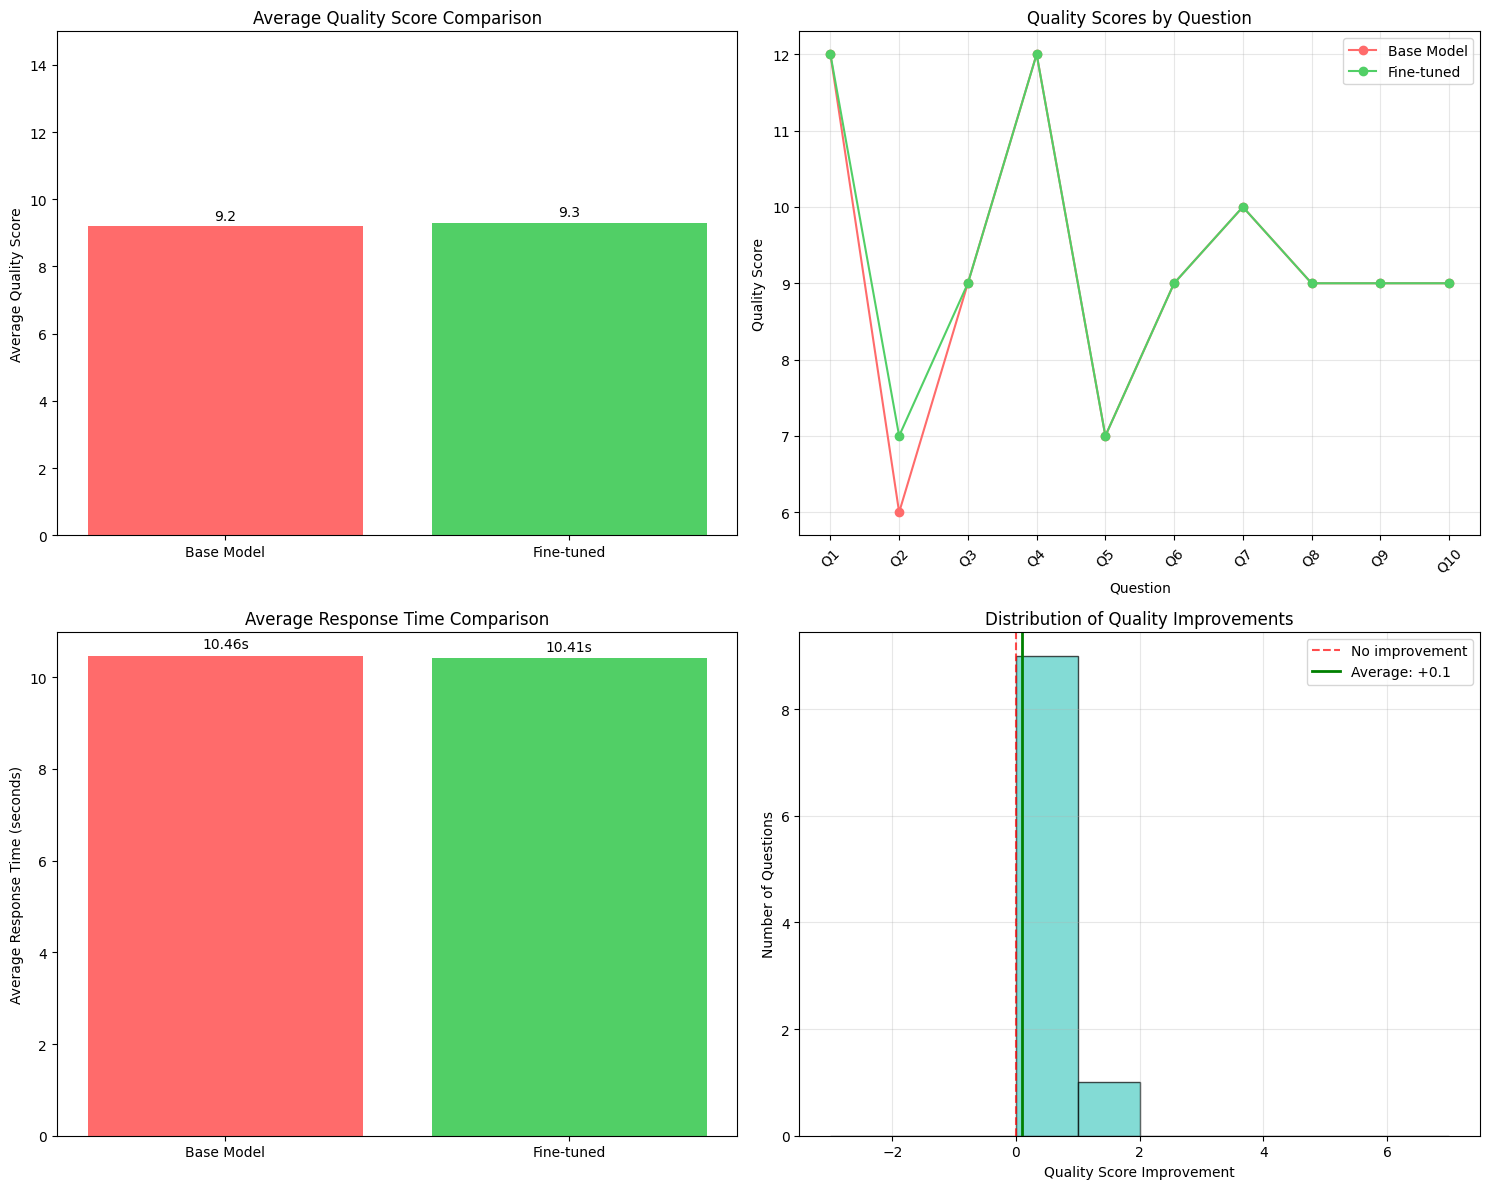

📈 Visualizations created successfully!


In [ ]:
if analysis.get('avg_finetuned_score'):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    ax1.bar(['Base Model', 'Fine-tuned'], 
            [analysis['avg_base_score'], analysis['avg_finetuned_score']], 
            color=['#ff6b6b', '#51cf66'])
    ax1.set_ylabel('Average Quality Score')
    ax1.set_title('Average Quality Score Comparison')
    ax1.set_ylim(0, 15)
    
    for i, v in enumerate([analysis['avg_base_score'], analysis['avg_finetuned_score']]):
        ax1.text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom')
    
    questions_short = [f"Q{i+1}" for i in range(len(analysis['base_scores']))]
    x = range(len(questions_short))
    
    ax2.plot(x, analysis['base_scores'], 'o-', label='Base Model', color='#ff6b6b')
    if analysis['finetuned_scores']:
        ax2.plot(x, analysis['finetuned_scores'], 'o-', label='Fine-tuned', color='#51cf66')
    
    ax2.set_xlabel('Question')
    ax2.set_ylabel('Quality Score')
    ax2.set_title('Quality Scores by Question')
    ax2.legend()
    ax2.set_xticks(x)
    ax2.set_xticklabels(questions_short, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Response time comparison
    ax3.bar(['Base Model', 'Fine-tuned'], 
            [analysis['avg_base_time'], analysis['avg_finetuned_time']], 
            color=['#ff6b6b', '#51cf66'])
    ax3.set_ylabel('Average Response Time (seconds)')
    ax3.set_title('Average Response Time Comparison')
    
    for i, v in enumerate([analysis['avg_base_time'], analysis['avg_finetuned_time']]):
        ax3.text(i, v + max(analysis['avg_base_time'], analysis['avg_finetuned_time'])*0.01, 
                 f'{v:.2f}s', ha='center', va='bottom')
    
    # Improvement distribution
    improvements = analysis['improvements']
    ax4.hist(improvements, bins=range(-3, 8), alpha=0.7, color='#4ecdc4', edgecolor='black')
    ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No improvement')
    ax4.axvline(x=analysis['avg_improvement'], color='green', linestyle='-', linewidth=2, 
                label=f'Average: {analysis["avg_improvement"]:+.1f}')
    ax4.set_xlabel('Quality Score Improvement')
    ax4.set_ylabel('Number of Questions')
    ax4.set_title('Distribution of Quality Improvements')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Visualizations created successfully!")
else:
    print("⚠️ Insufficient data for visualizations")

## Results

In [ ]:
detailed_results = []

for result in batch_results:
    row = {
        'question': result['question'],
        'base_response': result['base_result']['response'] if result['base_result']['success'] else 'Failed',
        'base_score': result['base_score'],
        'base_time': result['base_result']['generation_time'] if result['base_result']['success'] else 0,
        'base_success': result['base_result']['success']
    }
    
    if result['finetuned_result'] and result['finetuned_result']['success']:
        row.update({
            'finetuned_response': result['finetuned_result']['response'],
            'finetuned_score': result['finetuned_score'],
            'finetuned_time': result['finetuned_result']['generation_time'],
            'finetuned_success': True,
            'quality_improvement': result['finetuned_score'] - result['base_score'],
            'time_difference': result['finetuned_result']['generation_time'] - result['base_result']['generation_time']
        })
    else:
        row.update({
            'finetuned_response': 'Not available',
            'finetuned_score': 0,
            'finetuned_time': 0,
            'finetuned_success': False,
            'quality_improvement': 0,
            'time_difference': 0
        })
    
    detailed_results.append(row)

df = pd.DataFrame(detailed_results)

print("📊 Results Summary Table:")
summary_df = df[['question', 'base_score', 'finetuned_score', 'quality_improvement', 'base_time', 'finetuned_time']].copy()
summary_df['question'] = summary_df['question'].str[:50] + '...'  # Truncated
summary_df = summary_df.round(2)
display(summary_df)

📊 Results Summary Table:


,question,base_score,finetuned_score,quality_improvement,base_time,finetuned_time
0,What is the purpose of the Hansard parliamenta...,12,12,0,9.17,8.83
1,How are parliamentary debates documented and p...,6,7,1,12.27,8.43
2,What role do parliamentary records play in dem...,9,9,0,9.86,9.84
3,How can citizens access and use Hansard record...,12,12,0,7.86,10.21
4,What information is typically included in parl...,7,7,0,9.85,9.77
5,Why is it important to maintain accurate recor...,9,9,0,9.75,10.37
6,What is the difference between Hansard and oth...,10,10,0,11.04,9.86
7,How do parliamentary records support transpare...,9,9,0,11.43,12.02
8,What are the legal requirements for maintainin...,9,9,0,11.10,12.45
9,How have parliamentary record-keeping practice...,9,9,0,12.33,12.35
